<h3>Multi-scale Topographic Surface Roughness Analysis of the North Carolina Coastal Plain Exploratory Analysis and Classification</h3>

In this notebook we explore ways to differentiate the Mid-Atlantic Coastal Plain from its upland Piedmont counterpart. What we seek is some means, via one or more geomorphic/geomorphometric measures, of reliably identifying the boundary between the two provinces, a.k.a. locating the 'Fall-Line', such that we can model and map. 

We'll begin by employing some simple graphic products. If the plots look promising, we'll then move on to look at the distribution and explore non-supervised classifiers (our product detector) as a means to discriminate. 

The overarching assumption here is that the coastal plain province, and coastal plains in general and in some meaningful way, present a less topographically varied (i.e. rough) character than do the interior uplands [onto which the coastal plains abutt). Further, we assume that, in the presence of true assumptions, we can further identify, quantitatively model, and go on to map this difference and the two provinces--reliably. Repeatably. Maybe even globally!

**The data:**
0. The raw data from which the standard deviation products that follow are generated is a LiDAR-generated DEM for the Mid-Atlantic US coastline spanning from GA to VA. 

** Data derrivatives to explore:**
1.  Standard Deviation of Elevation (SDz): the standard deviation of the elevation surface computed using a moving (3x3) neighborhood window

2. Standard Deviation of Slope (SDs): the standard deviation of the slope surface (1st derivative of elevation) using a moving (3x3) neighborhood window

3. Standard Deviation of Profile Curvature: the standard deviation of the profile curvature (2nd derivative of elevation) using a moving (3x3) nieghborhood window. 

4. Standard Deviation of Mean Curvature: the standard deviation of the mean curvature (profile+tangent/2) using a moving (3x3) nieghborhood window. 

Note that we can increase the size of the neighborhood window if desired.

<h4>How to generate derivative products in GRASS:</h4>

The basic idea is to use neighborhood analysis (via GRASS's r.neighbors command) to extract the derivative of interest. Then, we extract a representative sample from the derivative surface and ship these data off to Python for analysis...

_Example:_
1. Generate a standard deviation surface of elevation:
r.neighbors --overwrite input=Halifax_Elev_10ft@user output=Halifax_SDz_10ft method=stddev

2. Extract a random sample of 2500 points across the SDz surface, add the x-y coordinate values to the db, and export for analysis:<br />
-r.random input=Halifax_Elev_SDz_10ft npoints=2500 vector=Halifax_ElevSDz_2500pts<br />
-v.db.addcolumn Halifax_ElevSDz_2500pts columns="x double precision, y double precision"<br />
-v.to.db map=Halifax_ElevSDz_2500pts option=coor columns=x,y<br />
-v.out.ogr input=Halifax_ElevSDz_2500pts output=/Users/paulp/t format=CSV <br />


and continue on to Jupyter...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KernelDensity
#from sklearn.model_selection import GridSearchCV
from statsmodels.nonparametric.kde import KDEUnivariate

sns.set()
%matplotlib inline

**For Topographic Elevation:**

In [40]:
### Load the Data:

datapath='/Users/paulp/GoogleDrive/projects/CoastalPlains/data/'
fn='midatl_elev_7kSamplePts.csv' # 'Halifax_ElevSDz_2500pts.csv'

df = pd.read_csv(datapath+fn)
df['z']=df.value*1.0
df = df.drop(['value'], axis=1)

**Topographic Elevation:  Simple Scatter Plots**

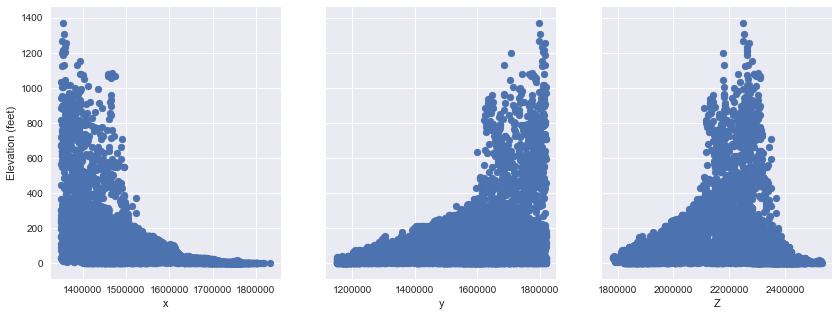

In [41]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5), sharey=True)

ax1.scatter(df.x, df.z)
ax1.set_xlabel('x')
ax1.set_ylabel('Elevation (feet)')

ax2.scatter(df.y, df.z)
ax2.set_xlabel('y')

df['Z']=(df.x**2 + df.y**2)**0.5
ax3.scatter(df.Z, df.z)
ax3.set_xlabel('Z')


The plot of x vs. elevation (leftmost of the three) suggests that the coastal plain/piedmont boundary might be in evidence at approximately x=1,630,000 ft, at something less than 50 feet in elevation. The remaining plots do not advance similar evidence--which should not be too surprising since the N-S direction (which the y coordinate prinicpally supports) runs more or less in parallel with the trend line of the boundary we seek. The derived Z is an experimental blend of x and y (representing the vector from the Cartesian origin out to the sample points). Is Z a failed experiment? Perhaps.

**Topographic Elevation:  Kernel Density Estimates**

(0, 100)

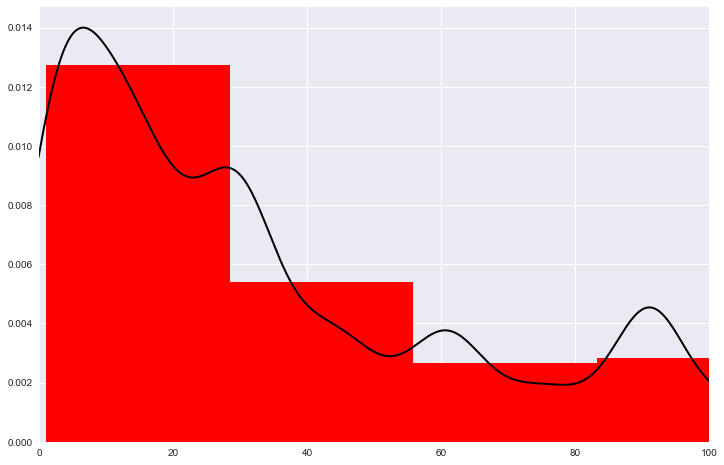

In [42]:
kde = KDEUnivariate(df.z)
kde.fit(bw=5.0)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df.z, bins=50, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');
ax.set_xlim(0,100)
#ax.plot(kde.support, kde.cdf)

Based on the KDE it is possible that the coastal plain/piedmont boundary is located in the transition zone somewahere between bins 30 and 50...

0.680668960836


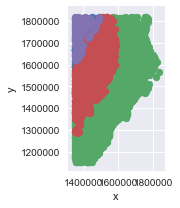

In [104]:
from sklearn.cluster import KMeans
from sklearn import metrics

X=df['z'][:,np.newaxis]

y=KMeans(init='k-means++', n_clusters=4)
y.fit(X)
y.predict(X)

print(metrics.silhouette_score(X, y.labels_, metric='euclidean'))

### assign data sample points to clusters based on model labels:
df['cluster']=[lbl for lbl, cat in zip(y.labels_, df['cat'])]

fg=sns.FacetGrid(data=df, hue='cluster', aspect=0.85)
fg.map(plt.scatter, 'x', 'y')

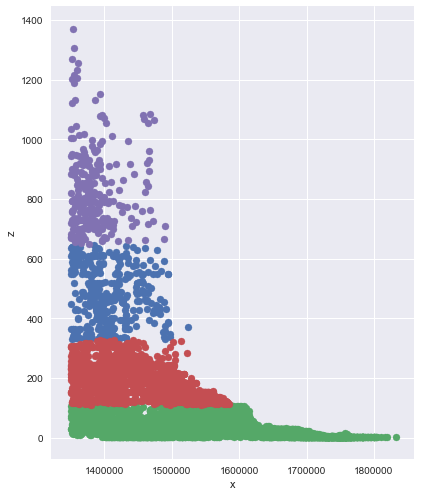

In [105]:
fg=sns.FacetGrid(data=df, hue='cluster', size=7, aspect=0.85)
fg.map(plt.scatter, 'x', 'z')

K-means with n=2 clusters breaks the elevation data at around 400 ft above MSL which, while interesting, is beyond the anticipated transition by more than 300 feet, so...

K-means with n=3 clusters inserts a break at about 150 feet above MSL which is closer to the break seen in the scatter plot at around 50 or so feet (where we are for the moment assuming the 'fall-line' to 'fall') but...

K-means with n=4 begins to split the data across higher elevations--around 675 to 700 feet--which suggests that we've gotten everything from K-means that it's going to give. 

<h4>Standard Deviation Slope (SDs):</h4>

In GRASS:

r.neighbors --overwrite input=Halifax_Slope_10ft output=Halifax_SDs_100m method=stddev

1. Generate a standard deviation surface of relevation:
r.neighbors --overwrite input=Halifax_Slope_10ft@user output=Halifax_SDs_10ft method=stddev

2. Extract a random sample of 2500 points across the SDz surface, add the x-y coordinate values to the db, and export for analysis:<br />
-r.random input=Halifax_Slope_SDs_10ft npoints=2500 vector=Halifax_SlopeSDs_2500pts<br />
-v.db.addcolumn Halifax_SlopeSDs_2500pts columns="x double precision, y double precision"<br />
-v.to.db map=Halifax_SlopeSDs_2500pts option=coor columns=x,y<br />
-v.out.ogr input=Halifax_SlopeSDs_2500pts output=/Users/paulp/t format=CSV <br />


In [6]:
### Load the Data:
datapath='/Users/paulp/GoogleDrive/projects/CoastalPlains/data/'
fn='Halifax_SlopeSDs_2500pts.csv'

df = pd.read_csv(datapath+fn)
df['z']=df.value
df = df.drop(['cat', 'value'], axis=1)
#df

**Standard Deviation of Slope:  Simple Scatter Plots of the Data**

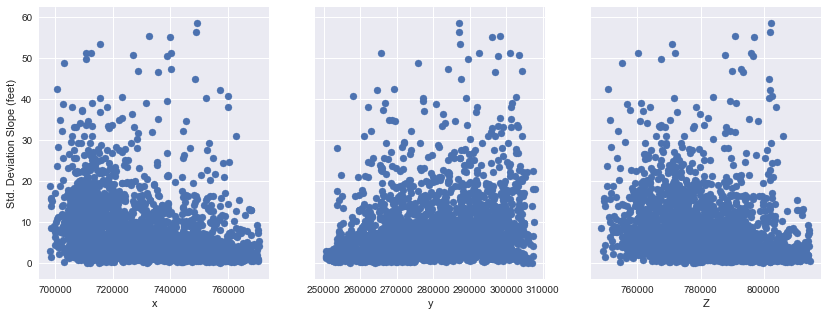

In [7]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5), sharey=True)

ax1.scatter(df.x, df.z)
ax1.set_xlabel('x')
ax1.set_ylabel('Std. Deviation Slope (feet)')

ax2.scatter(df.y, df.z)
ax2.set_xlabel('y')

df['Z']=(df.x**2 + df.y**2)**0.5
ax3.scatter(df.Z, df.z)
ax3.set_xlabel('Z')

**Standard Deviation of Slope:  Kernel Density Estimates**

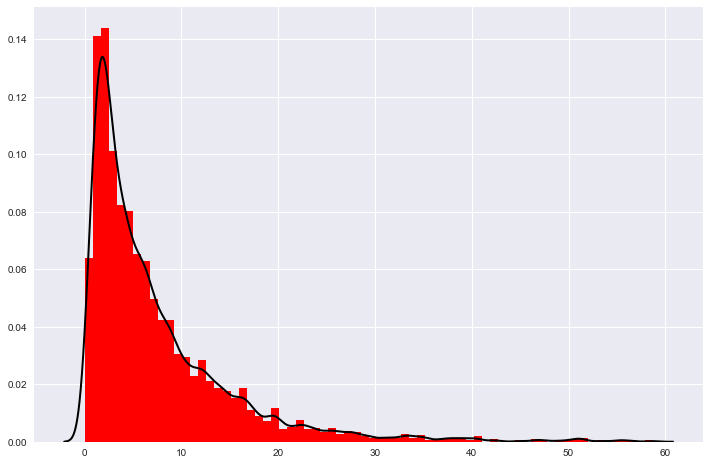

In [10]:
kde = KDEUnivariate(df.z)
kde.fit(bw=0.7)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df.z, bins=70, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');
#ax.plot(kde.support, kde.cdf)

**Topographic Slope:  Kernel Density Estimates**

In [16]:
### Load the Data:
datapath='/Users/paulp/GoogleDrive/projects/CoastalPlains/data/'
fn='Halifax_Slope_2500pts.csv'

df = pd.read_csv(datapath+fn)
df['z']=df.value
df = df.drop(['cat', 'value'], axis=1)
#df

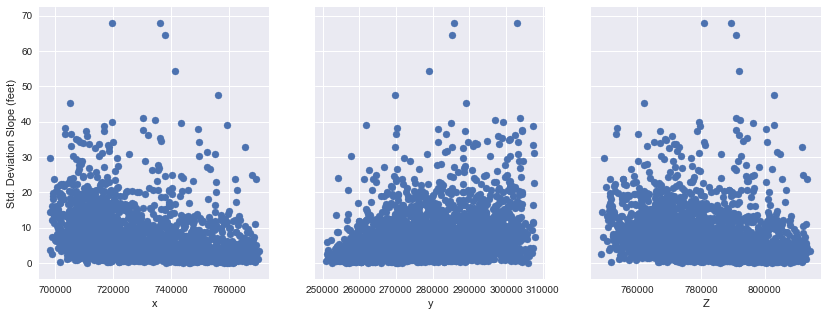

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5), sharey=True)

ax1.scatter(df.x, df.z)
ax1.set_xlabel('x')
ax1.set_ylabel('Slope')

ax2.scatter(df.y, df.z)
ax2.set_xlabel('y')

df['Z']=(df.x**2 + df.y**2)**0.5
ax3.scatter(df.Z, df.z)
ax3.set_xlabel('Z')

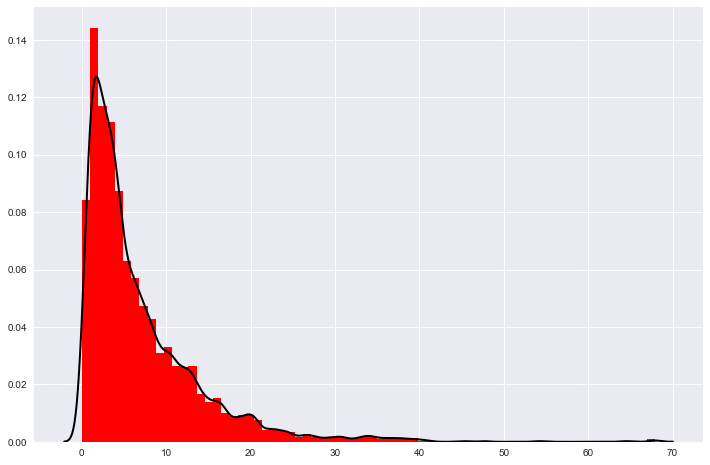

In [23]:
kde = KDEUnivariate(df.z)
kde.fit(bw=0.7)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(df.z, bins=70, normed=True, color='red')
ax.plot(kde.support, kde.density, lw=2, color='black');
#ax.plot(kde.support, kde.cdf)

It would appear that the changes in the character of the landscape in transitioning form coastal plain to upland (piedmont) is subtle. The trend in both elevation and slope are visible in cross-sectional profiles of the Halifax study area, but the change, as mentioned, is indeed subtle. By eye, one can see the shift in trend, but at larger mapping scales these trends are all but invisible. 

Perhaps at smaller mapping scales, where high frequency variations in the surface are filtered, we might be able to detect with some confidence the "fall-line" boundary. 